# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)) [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html). We gratefully acknowledge the authors of Seurat for the tutorial. In the meanwhile, we have added and removed a few pieces.  
    
The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data

In [78]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0


In [12]:
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

In [34]:
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/3k/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

### Read covid data:
# lungFilename = "./data/vieira19_Alveoli_and_parenchyma_anonymised.processed.h5ad"
# nasalFilename = "./data/vieira19_Nasal_anonymised.processed.h5ad"
# adata = covidData = sc.read_h5ad(nasalFilename) #

... reading from cache file cache/data-filtered_gene_bc_matrices-3k-matrix.h5ad


In [35]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [36]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

In [37]:
### Don't transpose at the beginning. Better to process and clean everything
### normally, and then transpose where indicated below.

In [40]:
#### Do everything in one function:
def runEverything(adata, geneBased):
    """
    Run everything in one go.

    Args:
        adata (scanpy object): The single cell data to analyze.
        geneBased (bool): If you want to flip the matrix and run gene-based instead
            of cell-based. If so, we transpose after all the processing, before the clustering.

    Returns:
        adata (scanpy object): The processed single cell data.
    """
    
    ## First filtering:
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    
    ## Mito filtering:
    mito_genes = adata.var_names.str.startswith('MT-')
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    
    adata = adata[adata.obs.n_genes < 2500, :]
    adata = adata[adata.obs.percent_mito < 0.05, :]
    
    ## Total-count normalize:
    sc.pp.normalize_total(adata, target_sum=1e4)
    ## Logarithmize:
    sc.pp.log1p(adata)
    adata.raw = adata
    
    ### If the user wants to do gene-based instead of cell-based:
    ## Doing it here means that we only keep highly-variable cells - e.g. dementor graph.
#     if geneBased:
#         adata = adata.transpose()
            
    
    ## Get highly-variable genes. This part probably needs manual input?
    sc.pp.highly_variable_genes(adata, min_disp=0.5)#, min_mean=0.0125, max_mean=3)
    sc.pl.highly_variable_genes(adata)
    ## Keep highly-variable genes:
    adata = adata[:, adata.var.highly_variable]

#     sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
    ## https://github.com/theislab/scanpy/issues/230?fbclid=IwAR1JPs8DcssFb-wAZGajo4LuQNASeCEr8CDbxRlVcfmOtPBRLY7l8N_Jnc8
    
    sc.pp.scale(adata, max_value=10)

    ### If the user wants to do gene-based instead of cell-based:
    ## Doing it here means that most genes are removed (since they're not highly variable) - e.g. starfish graph.
    if geneBased:
        adata = adata.transpose()
        
    ### PCA
    sc.tl.pca(adata, svd_solver='arpack')
    ### Nearest neighbors:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
    sc.tl.umap(adata)
    ### Cluster:
    sc.tl.leiden(adata, resolution = 0.75)
    
    ### Marker genes:
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

    ### Get the {clusters: top marker genes} dict
    clustersToTopGenes = dict(pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0])
    topGenes = list(clustersToTopGenes.values())

    sc.pl.umap(adata, color = ['leiden'] + topGenes)
    
    ### Write the clusters:
    # testData.obs.to_csv("clusteredStarfish.csv")

    return adata


In [21]:
geneBasedData.obs.to_csv("clusteredNasal.csv")

normalizing counts per cell
    finished (0:00:02)
extracting highly variable genes


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


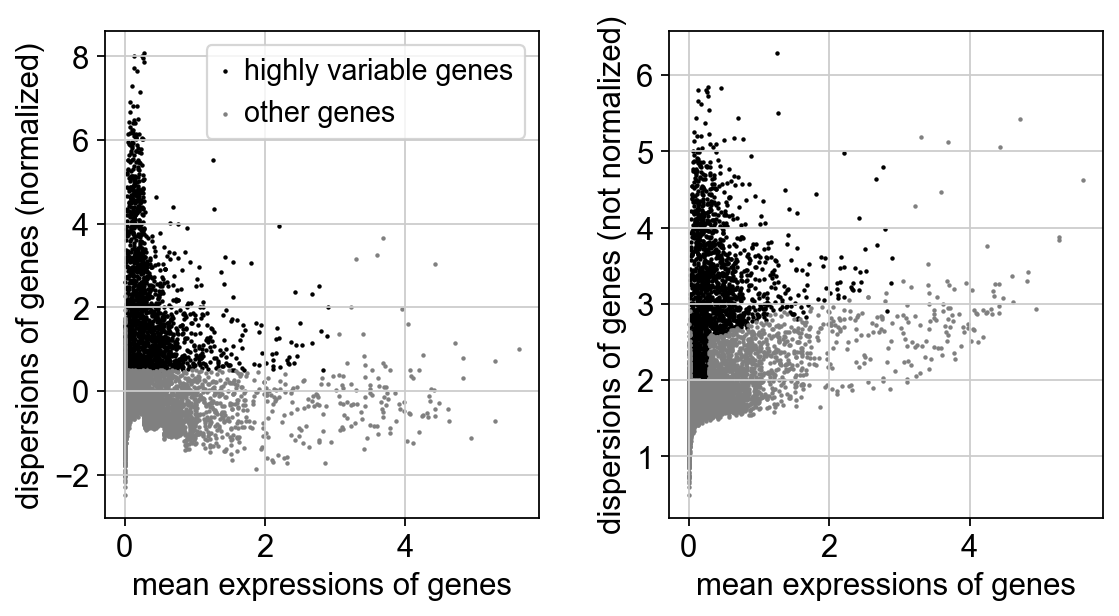

    on highly variable genes
computing PCA with n_comps = 50


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


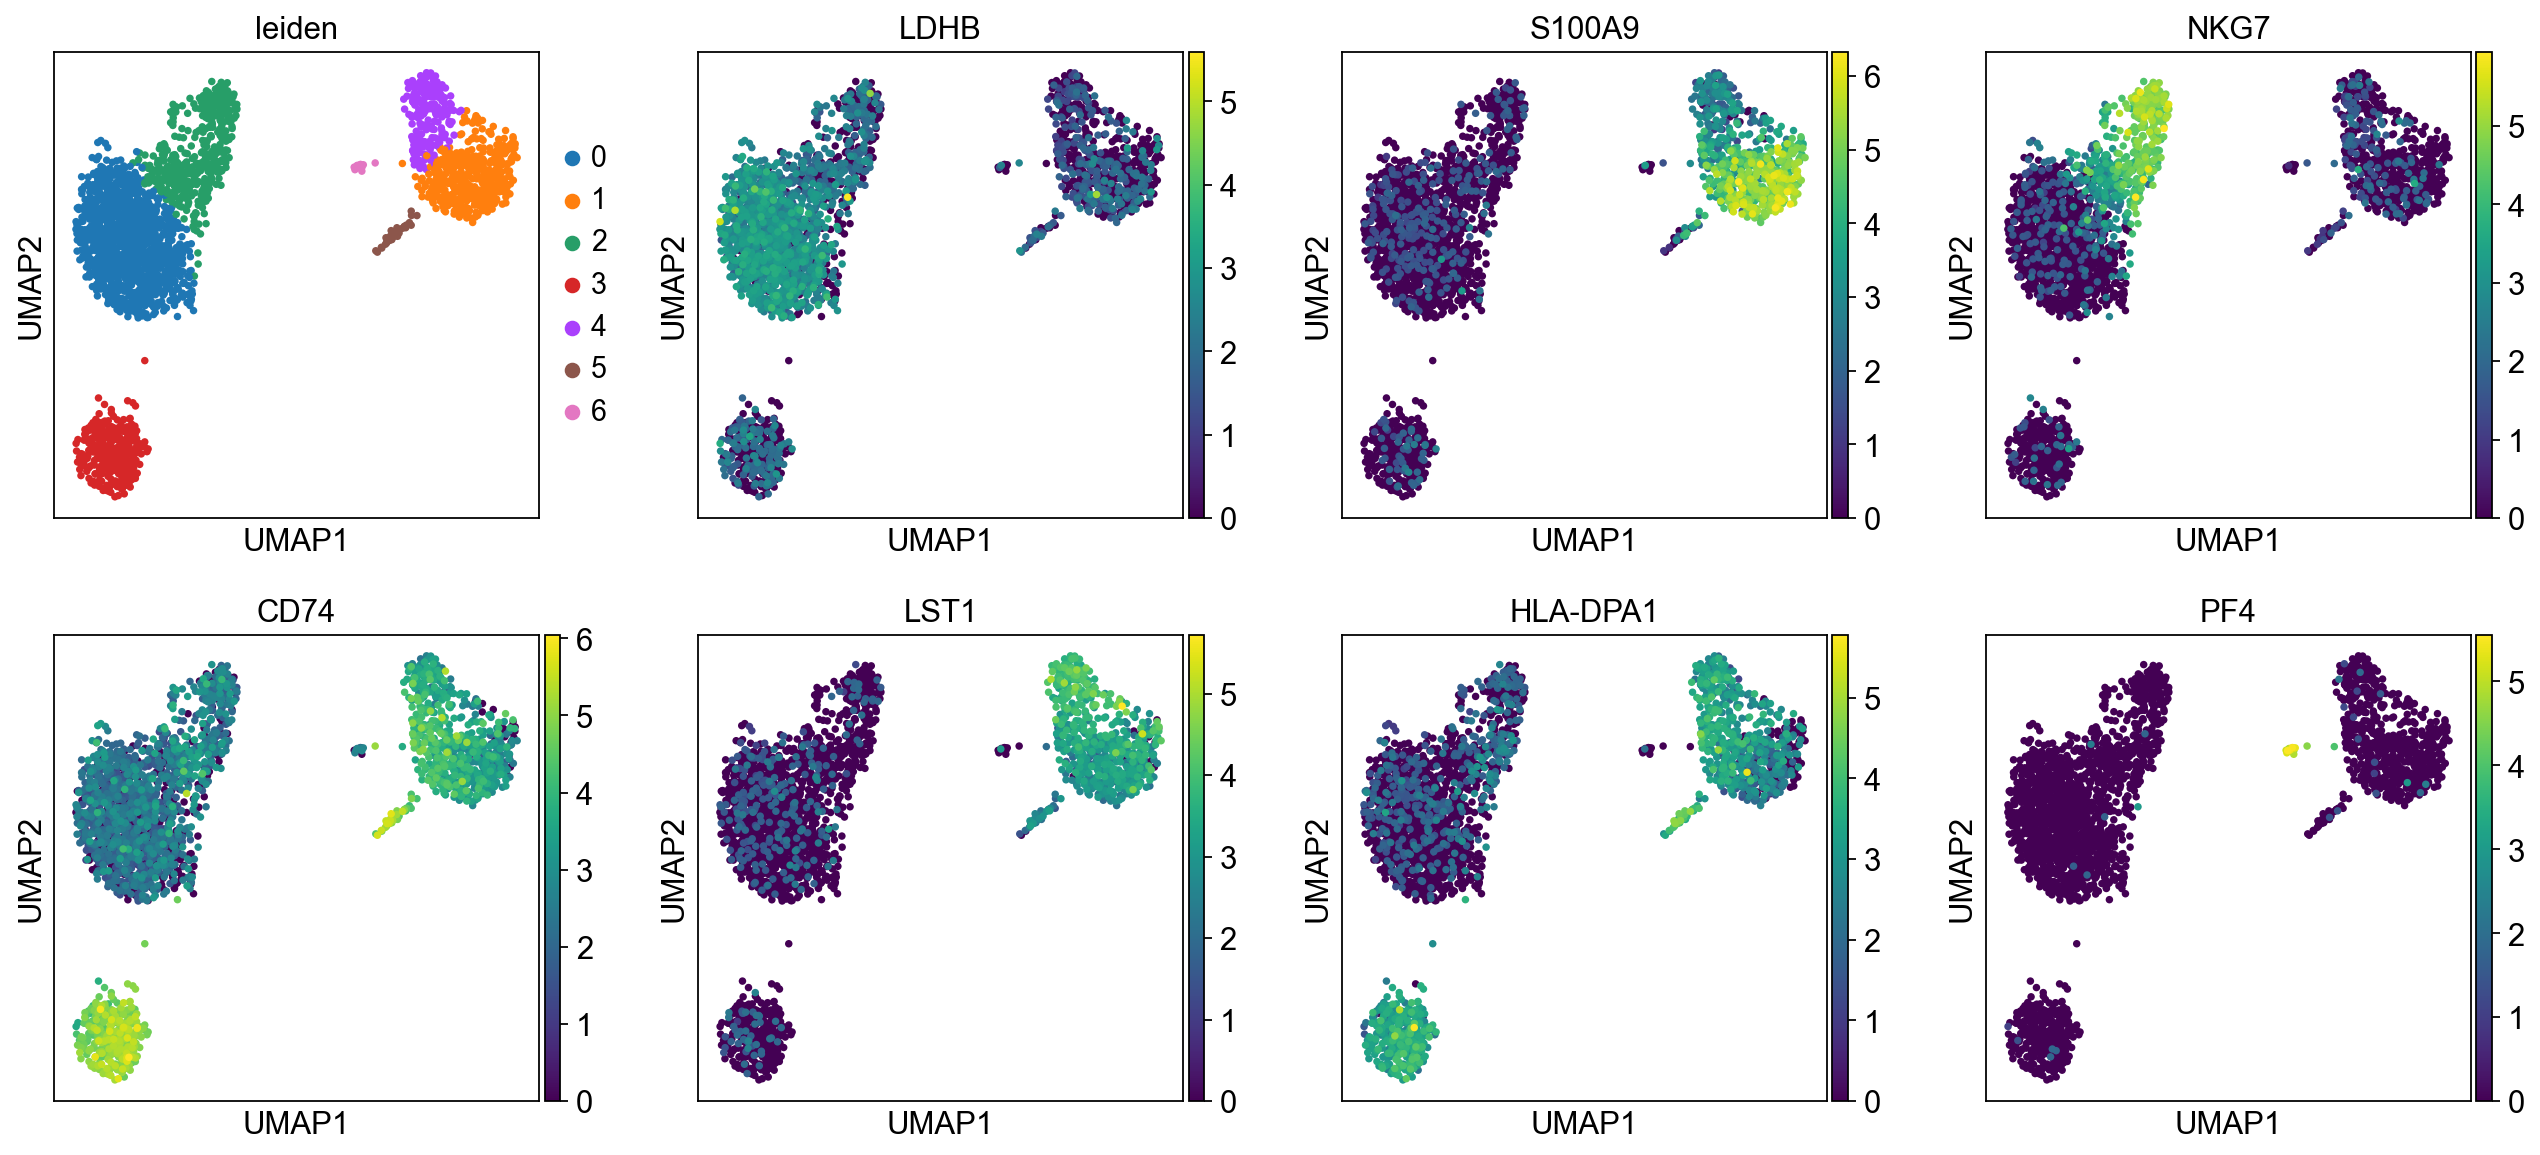

In [32]:
cellBasedData = runEverything(adata, geneBased = False)

normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


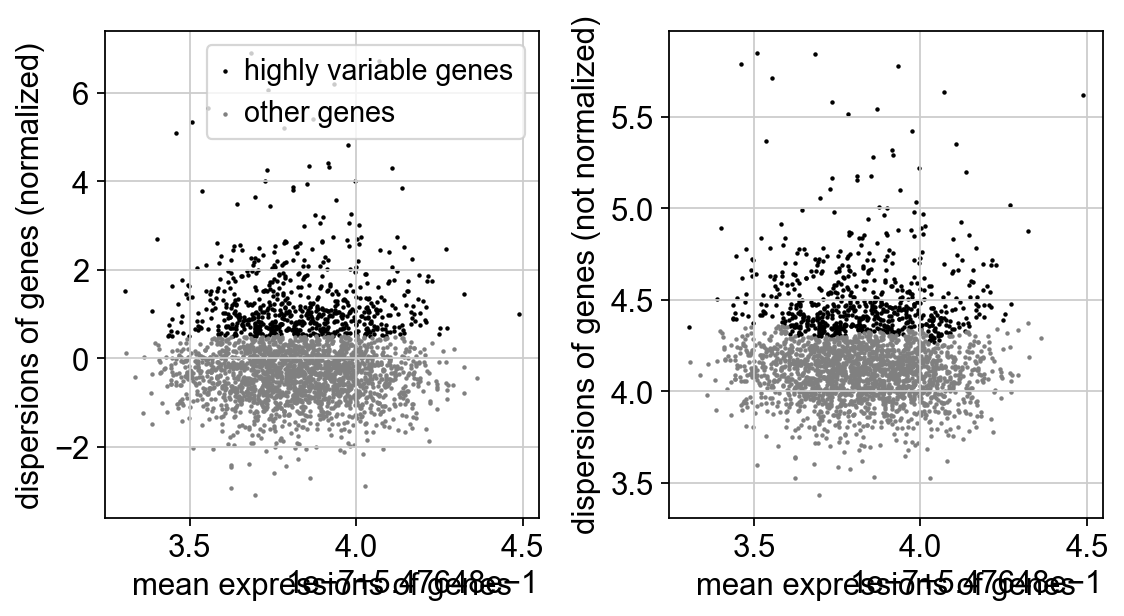

    on highly variable genes
computing PCA with n_comps = 50


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:912: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
ranking genes


/Users/jhostyk/anaconda3/envs/general/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


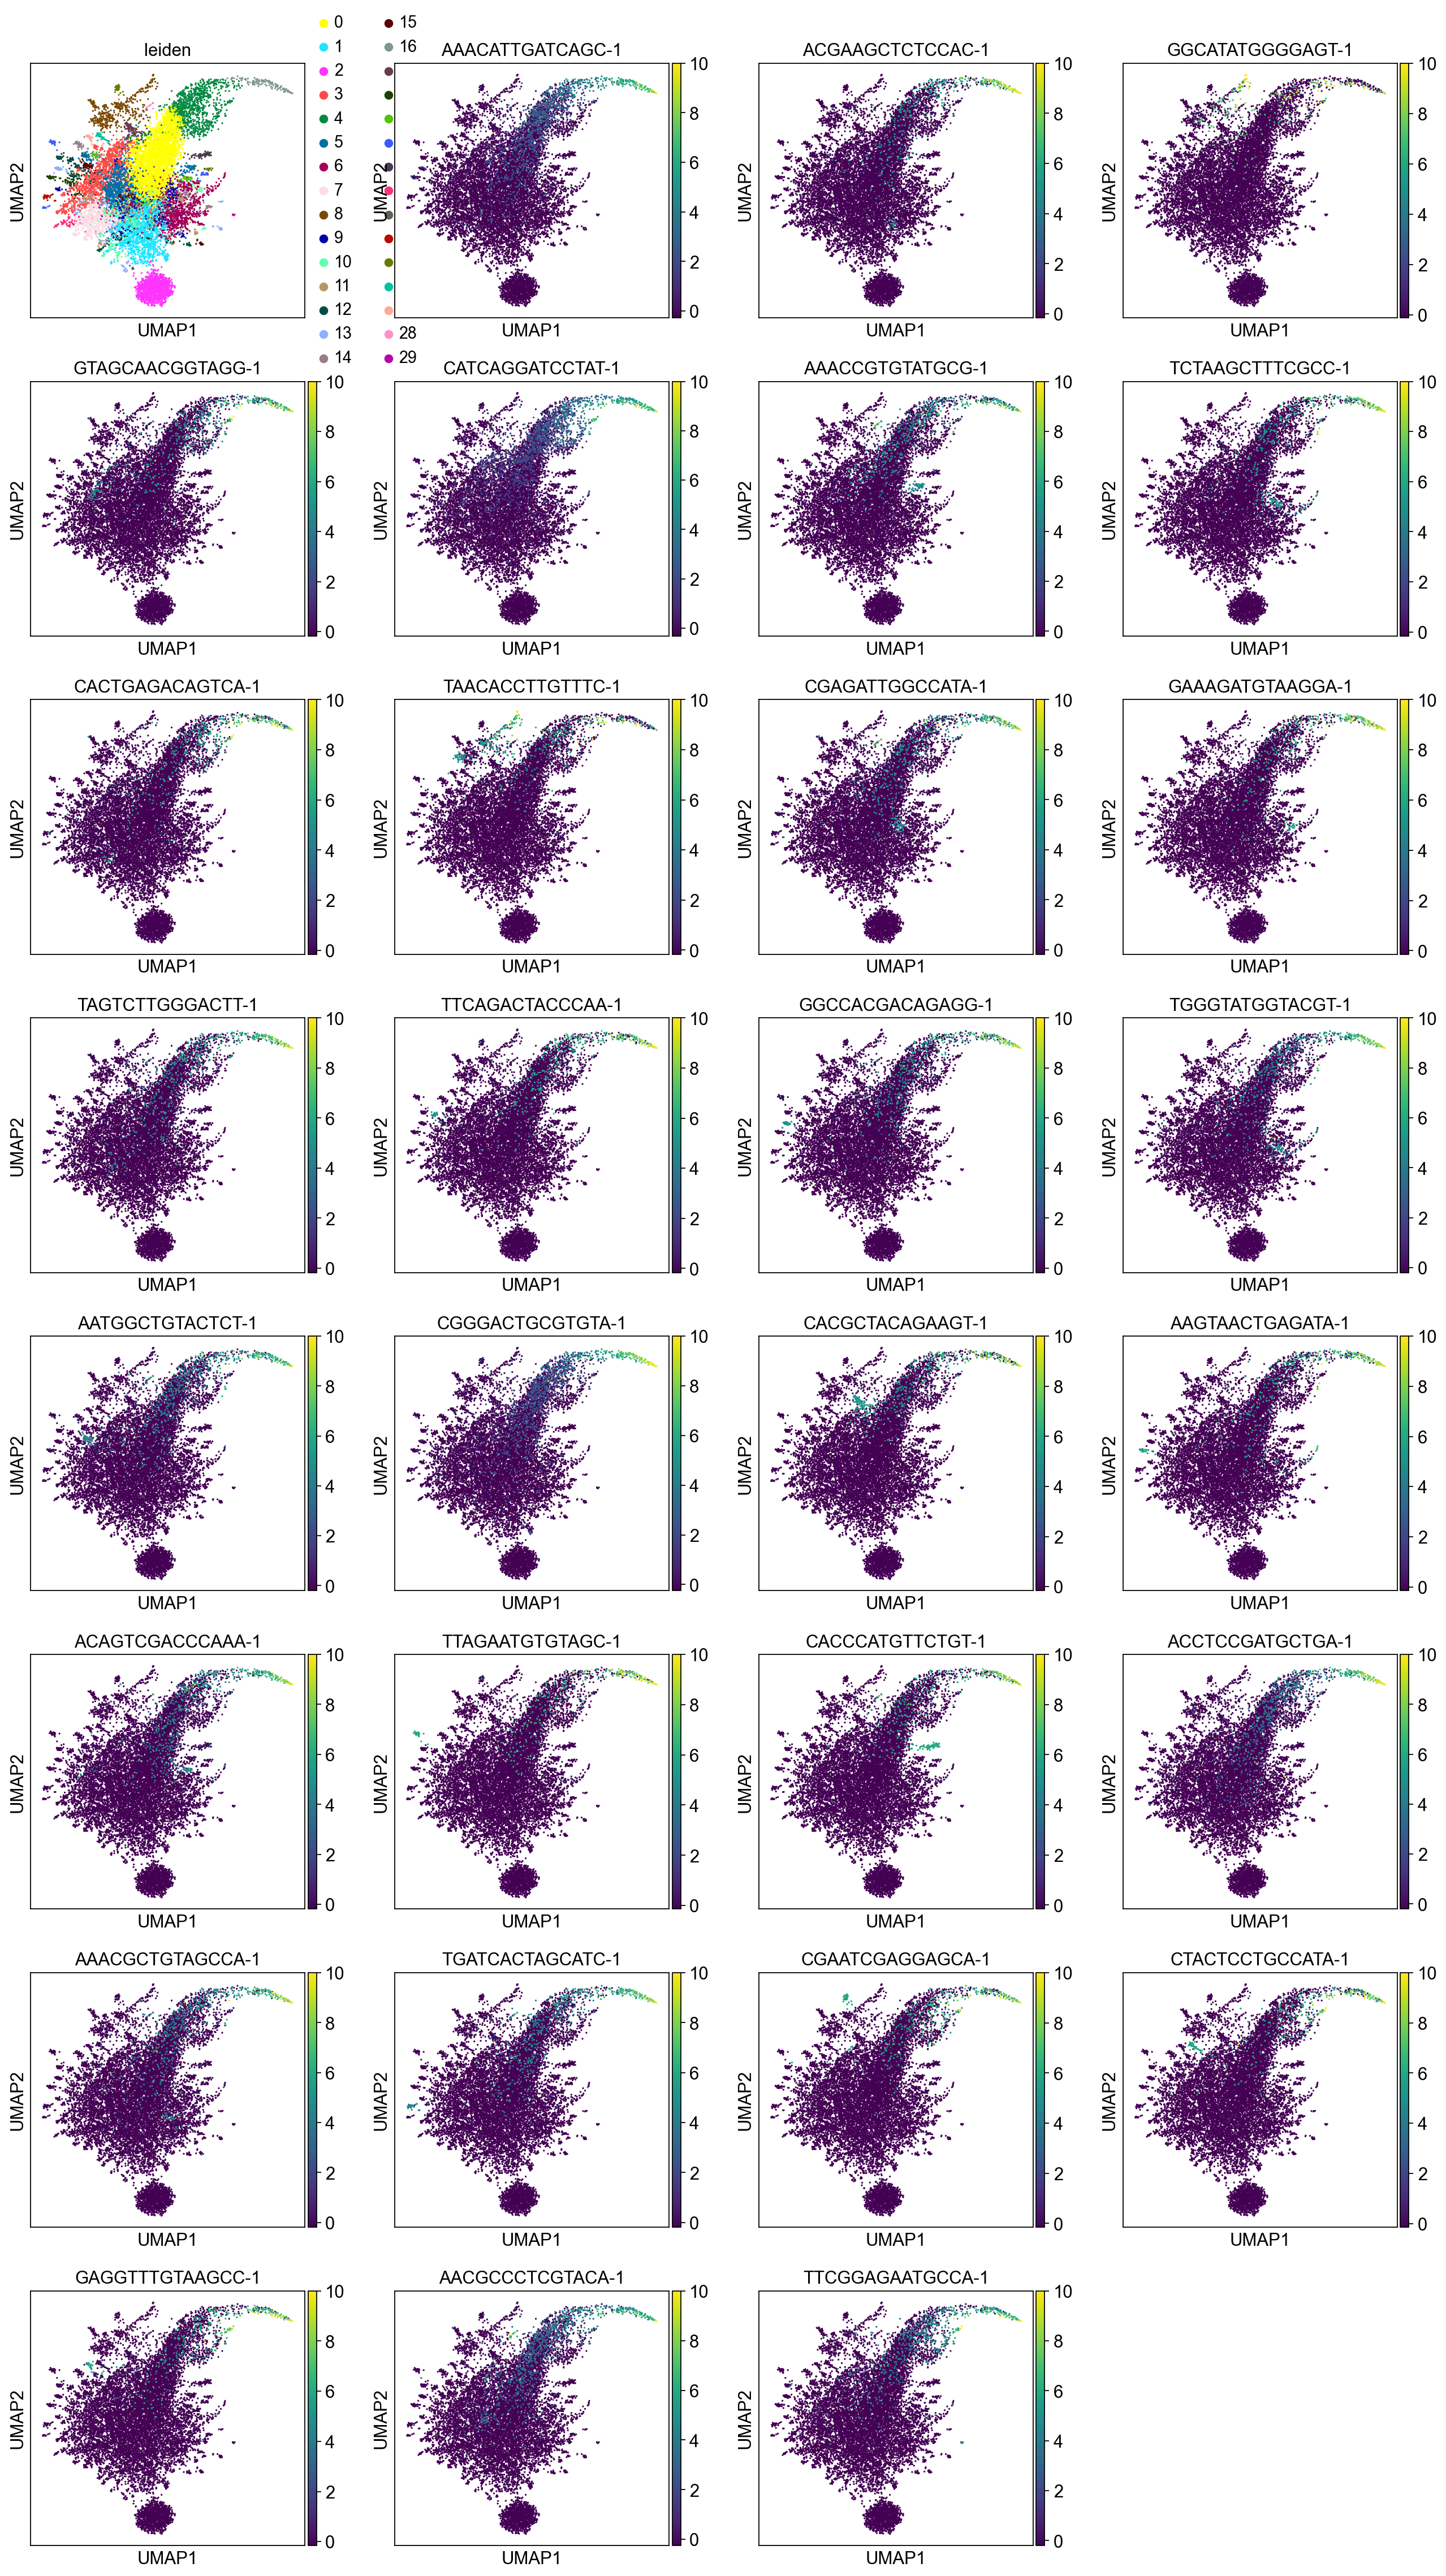

In [41]:
geneBasedData = runEverything(adata, geneBased = True)

In [19]:
def highlightListOfDots(adata, objectsToHighlight):
    """
    Light up a list of dots in a scanpy plot, and make a legend.

    Args:
        adata (scanpy object): The single cell data to analyze.
        objectsToHighlight (list): Either cells or genes
    """    
    numDots = len(geneBasedData.obs.index)
    defaultSize = 120000/numDots
    ### If you want to do separate plots for each:
#     for item in objectsToHighlight:
#         adata.obs[item] = adata.obs_names.isin([item])
#         sizes = pd.Series([300 if dot == item else defaultSize for dot in geneBasedData.obs.index])
#         sc.pl.umap(adata, color=item, size = sizes)
        
    ### Do one big plot:
    dotIndices = [dot if dot in objectsToHighlight else "0" for dot in adata.obs.index]
    sizes = pd.Series([300 if dot in objectsToHighlight else 10 for dot in adata.obs.index])
    alphas = [0.7 if dot in objectsToHighlight else 0.2 for dot in adata.obs.index]

    geneBasedData.obs["Marker Genes"] = dotIndices
    sc.pl.umap(geneBasedData, color=['Marker Genes'], size = sizes, alpha = 0.3)
#     kwargs = {'s': sizes, 'alpha': alphas}
#     sc.pl.umap(geneBasedData, color=['Marker Genes'], **kwargs)

... storing 'Marker Genes' as categorical


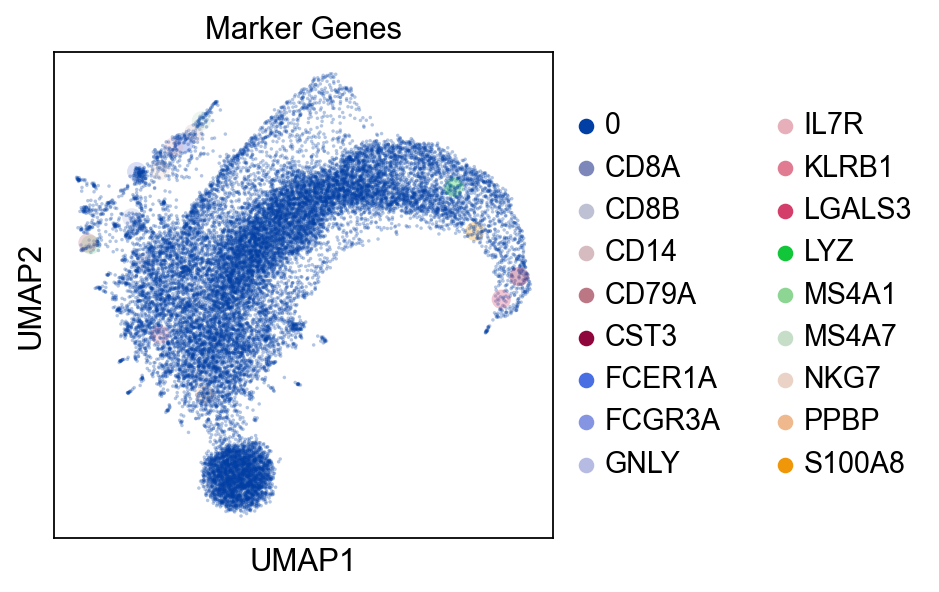

In [407]:
barcodes = ['AAACATACAACCAC-1', 'TTTCTACTTCCTCG-1']
genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14', 'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1', 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
highlightListOfDots(adata = geneBasedData, objectsToHighlight = genes)


In [142]:
def plotDifferentTypes(adata):
    sc.tl.tsne(adata)
    sc.pl.pca(adata, color = ['leiden'])
    sc.pl.umap(adata, color=['leiden'])
    sc.pl.tsne(adata, color=['leiden'])

computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:16)


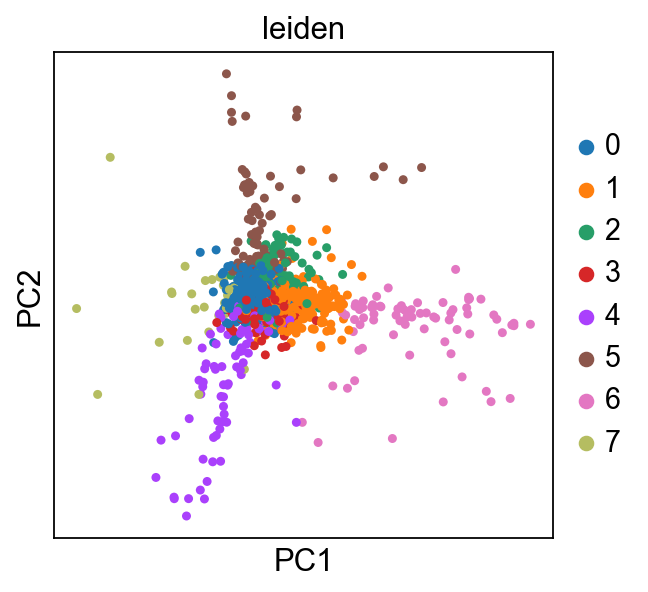

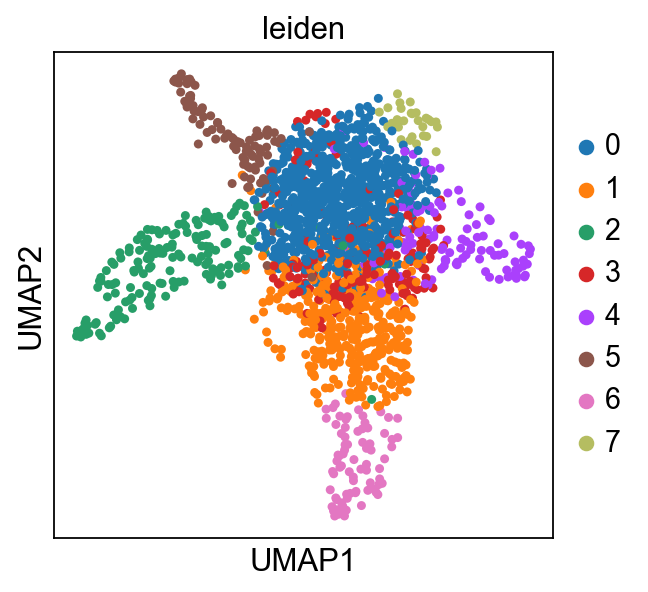

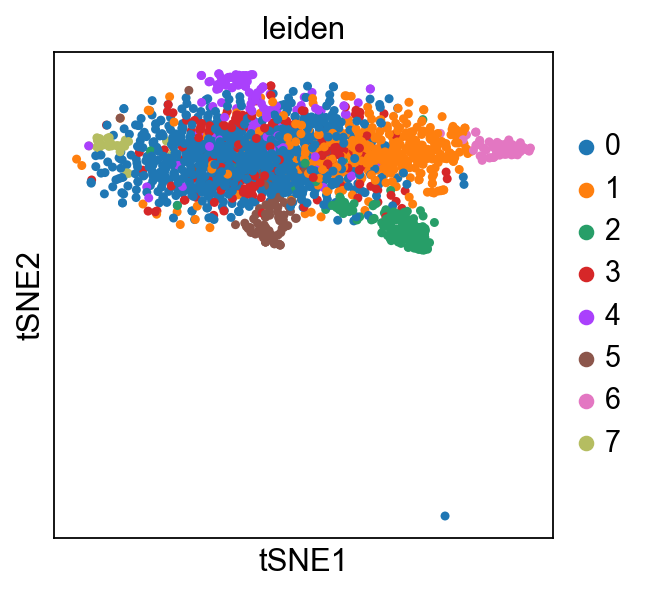

In [305]:
plotDifferentTypes(geneBasedData)

... storing 'Marker Genes' as categorical


Neighbors: Index(['PLEKHM2', 'C2orf68', 'DHX30', 'PCYOX1L', 'DHX16', 'RARS2', 'REV3L',
       'ACE2', 'TRPS1', 'ANO6', 'CD276', 'DOK4', 'DDX49'],
      dtype='object', name='index')


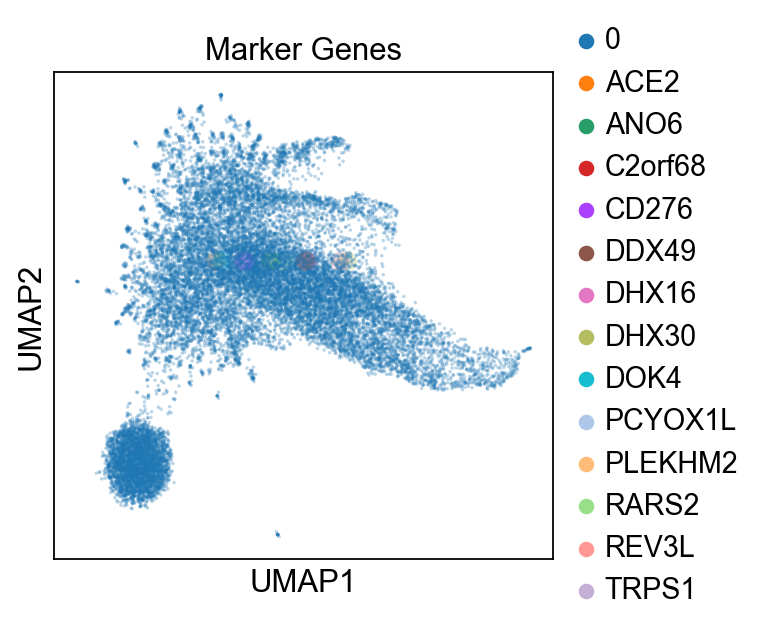

In [20]:
# geneBasedData.obsm["X_umap"]
gene = "ACE2"
dotIndex = [True if dot in [gene] else False for dot in geneBasedData.obs.index]
adata.obs[gene] = adata.obs_names.isin([gene])
genesUMAPcoords = geneBasedData.obsm["X_umap"][dotIndex]
x, y = genesUMAPcoords[0]
window = 0.002
xUpper = x + window
xLower = x - window
yUpper = y + window
yLower = y - window
umapXs = pd.Series(geneBasedData.obsm["X_umap"][:, 0])
umapYs = pd.Series(geneBasedData.obsm["X_umap"][:, 1])
isNeighbor = umapXs.between(xLower, xUpper) | umapYs.between(yLower, yUpper)


# window = 0.02
# pcs = geneBasedData.obsm["PCs"][dotIndex][0]
# isNeighbor = pd.Series([False]*len(geneBasedData.obs.index))
# for index, pc in enumerate(pcs):
#     upper = pc + window
#     lower = pc - window
#     pcsAtThisIndex = pd.Series(geneBasedData.obsm["PCs"][:, index])
# #     print (pc, index, len(isNeighbor), len(pcsAtThisIndex))
#     isNeighbor |= pcsAtThisIndex.between(lower, upper)

print ("Neighbors:", geneBasedData.obs.index[isNeighbor])
if len(geneBasedData.obs.index[isNeighbor]) < 20:
    highlightListOfDots(adata = geneBasedData, objectsToHighlight = geneBasedData.obs.index[isNeighbor])
else:
    print("You've got too many neighbors to plot.")


In [416]:
# geneBasedData.obsm["PCs"]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00136221, -0.01309944,  0.00984849, ...,  0.02085518,
         0.00470549, -0.0113228 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [306]:
# geneBasedData.obs.to_csv("clusteredStarfish.csv")
# missingGenes = ['NKG7', 'IL7R', 'CD8A', 'LYZ', 'CD14', 'MS4A7']

# for gene in missingGenes:
#     print (gene, gene in cellBasedData.var.index, gene in geneBasedData.var.columns)
